## Triplet's rate equation solving

In [5]:
import numpy as np
import matplotlib.pyplot as plt

k_isc = 1E-3        # 1/ns
tau_s = 98          # ns
k_risc = 2.2*1E-4   # 1/ns
tau_t = 100E+3      # ns
G = np.linspace(1E-12,20,200)
k_tta = 8*1E-9      # From literature (m^3/ns)
    
def triplet_cubic(g,param): 
    # aT^3 + 0*T^2 + b*T + G*c = 0
    
    a = (-1)*param
    b = (-1)*(1/tau_t) + (-1)*(k_risc) + (k_isc*k_risc)/((1/tau_s) + k_isc)
    c = 0.75 + 0.25*k_isc/((1/tau_s) + k_isc)    
    
    
    return np.roots([a,0,b,g*c])

def triplet_quad(g,param): 
    # aT^2 b*T + G*c = 0
    
    a = 0.25*tau_s*param*k_isc/(1+k_isc*tau_s) + (-1)*1.25*param
    b = (-1)*(1/tau_t) + (-1)*k_risc + (k_risc*k_isc*tau_s)/(1+k_isc*tau_s)
    c = 0.75 + (0.25*k_isc*tau_s)/(1+k_isc*tau_s)  
    
    return np.roots([a,b,g*c])


def Singlet_quad(T,g,param):
    return (0.25*tau_s*g + k_risc*tau_s*T + 0.25*param*tau_s*T*T)/(1+k_isc*tau_s)
def Singlet_cubic(T,g,param):
    return (0.25*g*tau_s + k_risc*tau_s*T)/(1+k_isc*tau_s)

def dump_graphs(x,y,filename):
    n = len(x)
    with open(filename,'w') as f:
        for i in range(n):
            f.write('{} {}\n'.format(x[i],y[i]))
            
singlet_funcs = {'quad': Singlet_quad,'cubic':Singlet_cubic}
triplet_funcs = {'quad': triplet_quad,'cubic':triplet_cubic}

def get_parameter_behavior(G,param_array,type_param):
    indx = 0
    for param in param_array:
        indx = indx+1
        EQE        = [] # efficiency for a given G
        g_allowed  = [] # G values in which the polynomial's roots are real

        for g in G:
            poly_sols      = triplet_funcs[type_param](g,param)
            real_poly_sols = [x.real for x in poly_sols if x.imag == 0 and x.real >=0]

            if real_poly_sols:
                if len(real_poly_sols) > 1:
                    print('duplicated sols')
                    
                singlet_density   = singlet_funcs[type_param](real_poly_sols[0],g,param)

                EQE.append(singlet_density/g)
                g_allowed.append(g)


        plt.plot(g_allowed,EQE,'--r',label='param:(%s)'%(param))
        #plt.legend()
        
        ax = plt.gca()
        #ax.set_xlim([xmin, xmax])
        ax.set_ylim([30, 100])
        plt.xlabel('Generation rate (m$^{-3}$ ns$^{-1}$)')
        plt.ylabel('IQE')
        
        #DUMP data
        #file_name = type_param+'_'+str(indx)+'.txt'
        #dump_graphs(g_allowed,EQE,file_name)
        
        
        #plt.show()
    #plt.legend()
    plt.show()


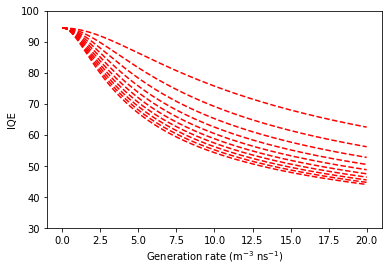

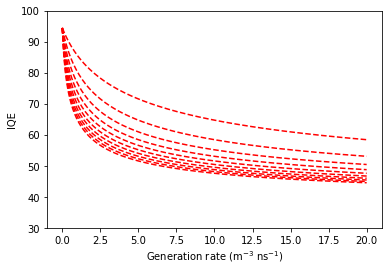

In [6]:
cubic_param_arr= np.linspace(1E-13,1E-12,10) # Our parameter m^6/ns
quad_param_arr = np.linspace(1E-8,1E-7,10) # literature's parameter (m^3/ns)

get_parameter_behavior(G,cubic_param_arr,'cubic')
get_parameter_behavior(G,quad_param_arr,'quad')